<a href="https://colab.research.google.com/github/DiegoABP/proyecto1/blob/main/Pulsares.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
 #Basad en
 #https://www.kaggle.com/code/nguyenn95/playground-series-season-3-episode-10#Playground-Series---Season-3,-Episode-10---Solution
 #https://www.kaggle.com/code/iqbalsyahakbar/ps3e10-first-attempt-at-playground-competition
train_data_original = pd.read_csv("train.csv")
test_data_original = pd.read_csv("test.csv")
original = pd.read_csv("Pulsar.csv")

train_data = train_data_original.drop(columns=["id"])
test_data = test_data_original.drop(columns=["id"])

In [3]:
#Se necesita hacer la correcion
#segun https://www.kaggle.com/competitions/playground-series-s3e10/discussion/393588
train_data[['EK','Skewness','EK_DMSNR_Curve','Skewness_DMSNR_Curve']] = train_data[['Skewness','EK','Skewness_DMSNR_Curve','EK_DMSNR_Curve']]
original[['EK','Skewness','EK_DMSNR_Curve','Skewness_DMSNR_Curve']] = original[['Skewness','EK','Skewness_DMSNR_Curve','EK_DMSNR_Curve']]
test_data[['EK','Skewness','EK_DMSNR_Curve','Skewness_DMSNR_Curve']] = test_data[['Skewness','EK','Skewness_DMSNR_Curve','EK_DMSNR_Curve']]

In [4]:
train_data.drop(columns=['Class']).describe()

,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve
count,117564.000000,117564.000000,117564.000000,117564.000000,117564.000000,117564.000000,117564.000000,117564.000000
mean,111.248300,46.713535,1.886385,0.503498,11.962921,26.190678,93.881076,8.037488
std,24.906474,6.102941,6.515466,1.127093,26.719946,20.041937,79.962110,3.840980
min,6.054688,24.783273,-1.791886,-1.730782,0.213211,7.370432,-1.976976,-2.597872
25%,104.546875,43.443390,-0.188956,0.049761,2.090301,14.955405,49.409136,6.742911
50%,116.664062,47.478932,0.091720,0.186498,2.808528,18.164924,83.421375,8.442883
75%,126.296875,50.862718,0.691613,0.395620,4.122910,24.732218,122.093290,10.003237
max,189.367188,93.602933,65.385974,7.879628,217.371238,109.890785,1191.000837,34.539844


In [5]:
test_data.describe()

,Mean_Integrated,SD,EK,Skewness,Mean_DMSNR_Curve,SD_DMSNR_Curve,EK_DMSNR_Curve,Skewness_DMSNR_Curve
count,78377.000000,78377.000000,78377.000000,78377.000000,78377.000000,78377.000000,78377.000000,78377.000000
mean,111.328650,46.729918,1.833997,0.494829,11.857477,26.075380,94.034477,8.048395
std,24.682112,6.088317,6.401282,1.111206,26.610344,19.929691,79.905613,3.826233
min,5.812500,24.772042,-1.791886,-1.788449,0.213211,7.448817,-1.976976,-2.556795
25%,104.585938,43.502110,-0.190423,0.050069,2.088629,14.954451,49.704203,6.755894
50%,116.554688,47.465944,0.090628,0.185460,2.803512,18.164951,83.322761,8.444376
75%,126.195312,50.854073,0.692126,0.394856,4.099498,24.547813,122.093290,9.973464
max,192.617188,91.808628,64.117478,8.069522,223.392141,110.544845,1072.793069,31.471559


In [6]:
#Imprime la cantidad de valores faltantes
def get_missing_values(data):
    missing_values = data.isna().sum()
    return len(missing_values[missing_values > 0].sort_values() )
get_missing_values(train_data)


0

In [7]:
get_missing_values(test_data)

0

#Preprocesamiento

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data.drop(columns=["Class"]), train_data.Class, test_size=0.1)
skew_cols = X_train.columns[2: 6].to_list() + [X_train.columns[-1]]

In [10]:
def transform_to_normal_using_log(x):
    min_values = np.min(x)
    base_values = np.ceil(np.abs(min_values)) # prevent 0 or negative
    return np.log(x + base_values)


log_pipeline = make_pipeline(
    FunctionTransformer(transform_to_normal_using_log)
)
preprocessing = ColumnTransformer([
    ("log", log_pipeline, skew_cols)
], remainder=StandardScaler())
df = pd.DataFrame(preprocessing.fit_transform(X_train), columns=X_train.columns)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)


#Entrenamiento

In [11]:
X_train = pd.DataFrame(preprocessing.fit_transform(X_train), columns=X_train.columns)
X_valid = pd.DataFrame(preprocessing.transform(X_valid), columns=X_valid.columns)
def score_dataset(X_train, X_valid, y_train, y_valid, model):
    model.fit(X_train, y_train)
    return model.score(X_valid, y_valid)
default_models = {
    "Logistic Reg": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "SVC": SVC()
}
acc_scores = {}
for model_name, model in default_models.items():
    acc_scores[model_name] = {"mean accuracy": score_dataset(X_train, X_valid, y_train, y_valid, model)}

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solv

In [12]:
acc_scores

{'Logistic Reg': {'mean accuracy': 0.9876669218338011},
 'Random Forest': {'mean accuracy': 0.9890278132176575},
 'SVC': {'mean accuracy': 0.9879220889682743}}

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


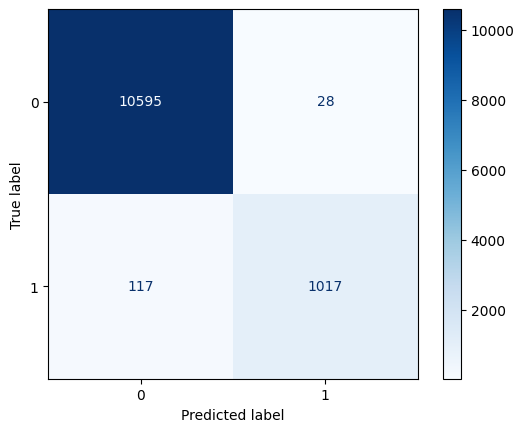

In [13]:
predictions = LogisticRegression().fit(X_train, y_train).predict(X_valid)
ConfusionMatrixDisplay(confusion_matrix(y_valid, predictions)).plot(cmap="Blues");
plt.show()
